In [1]:
import pandas as pd
import numpy as np
import collections

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import math
import random
import sklearn
import string
from tensorflow import keras


from util import rmse
from util import ndcg_k
from util import divSco_k
from util import gettail

reallyfinalbooks = pd.read_csv('reallyfinalbooks.csv')
reallyfinalratings = pd.read_csv('reallyfinalratings.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

traintable = pd.pivot_table(data=train, index="newuser_id", columns="newbook_id", values="rating").sort_index(axis=0).sort_index(axis=1)
testtable = pd.pivot_table(data=test, index="newuser_id", columns="newbook_id", values="rating").sort_index(axis=0).sort_index(axis=1)

tail = gettail(reallyfinalratings)

In [2]:
reallyfinalbooks["genre_list"] = reallyfinalbooks["genre"].apply(lambda x: x.split("|")[:-1])

In [3]:
genre_count = {}
for genre_list in reallyfinalbooks["genre_list"]:
    for genre in genre_list:
        if genre not in genre_count:
            genre_count[genre] = 0
        genre_count[genre] += 1
genre_count_list = [(genre, genre_count[genre]) for genre in genre_count]
genre_count_list.sort(key=lambda x: x[1])

In [4]:
all_genre_list = genre_count_list[288:] #only use genres that had been taged on multiple books
all_genre_list.reverse()
all_genre_list

[('to-read', 7679),
 ('currently-reading', 5337),
 ('favorites', 4096),
 ('romance', 2713),
 ('fiction', 2671),
 ('young-adult', 2219),
 ('fantasy', 2036),
 ('ya', 1384),
 ('contemporary', 1200),
 ('mystery', 977),
 ('paranormal', 950),
 ('historical-fiction', 799),
 ('contemporary-romance', 623),
 ('series', 619),
 ('new-adult', 541),
 ('book-club', 487),
 ('non-fiction', 463),
 ('science-fiction', 408),
 ('books-i-own', 399),
 ('urban-fantasy', 381),
 ('nonfiction', 377),
 ('thriller', 360),
 ('sci-fi', 352),
 ('classics', 313),
 ('historical', 311),
 ('vampires', 306),
 ('graphic-novels', 304),
 ('graphic-novel', 287),
 ('paranormal-romance', 267),
 ('dystopian', 267),
 ('kindle', 257),
 ('horror', 257),
 ('humor', 246),
 ('childrens', 227),
 ('comics', 222),
 ('chick-lit', 213),
 ('dystopia', 207),
 ('owned', 202),
 ('crime', 196),
 ('memoir', 193),
 ('erotica', 190),
 ('historical-romance', 142),
 ('middle-grade', 140),
 ('picture-books', 128),
 ('history', 117),
 ('sports', 112),

In [5]:
for genre, _ in all_genre_list:
    reallyfinalbooks[genre] = reallyfinalbooks["genre_list"].apply(lambda l: 1 if genre in l else 0)

In [6]:
reallyfinalbooks[[genre for genre, _ in all_genre_list]]

,to-read,currently-reading,favorites,romance,fiction,young-adult,fantasy,ya,contemporary,mystery,...,harry-bosch,theatre,theology,dance,baseball,on-writing,physics,photography,erotic,read-2015
0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,1,0,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
D = reallyfinalbooks[[genre for genre, _ in all_genre_list]].values
m = D.shape[0]
X = (D - np.mean(D, axis=0)) / np.sqrt(m)
u, s, vt = np.linalg.svd(X, full_matrices=False)

In [8]:
t = u @ np.diag(s)
print(t.shape)

(8000, 379)


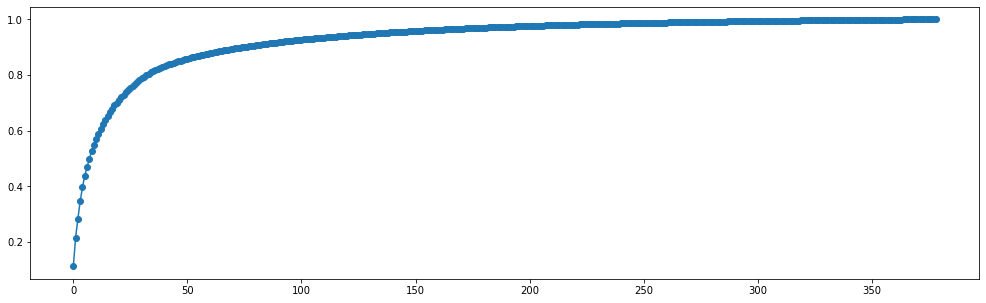

In [9]:
plt.figure(figsize=(17,5))
plt.plot(np.arange(len(s)), np.cumsum(s**2 / sum(s** 2)));
plt.scatter(np.arange(len(s)), np.cumsum(s**2 / sum(s** 2)));

In [10]:
np.cumsum(s**2 / sum(s** 2))

array([0.11285291, 0.21640028, 0.28382925, 0.34646042, 0.3964459 ,
       0.43828144, 0.46860979, 0.49882136, 0.52575916, 0.55001038,
       0.57166385, 0.58988044, 0.60768582, 0.62422386, 0.63972038,
       0.65346193, 0.66647348, 0.67926936, 0.69083977, 0.70133343,
       0.71116955, 0.72072138, 0.72995992, 0.73828044, 0.74617713,
       0.75399462, 0.76169863, 0.76898069, 0.77584652, 0.78214014,
       0.78841829, 0.79426039, 0.79974921, 0.80488172, 0.80993695,
       0.81455268, 0.81886428, 0.82270926, 0.82616474, 0.82929165,
       0.83233718, 0.83535645, 0.83835362, 0.84126274, 0.84402567,
       0.84668875, 0.84926109, 0.85175167, 0.85416593, 0.85651892,
       0.85876866, 0.86098696, 0.86314335, 0.86529183, 0.86739214,
       0.8694636 , 0.87147625, 0.87347632, 0.87541373, 0.87721893,
       0.87896716, 0.88065586, 0.88232924, 0.88395983, 0.88553471,
       0.88709471, 0.88860342, 0.89004649, 0.89145396, 0.89285332,
       0.89420503, 0.89554134, 0.89686278, 0.89816804, 0.89946

In [11]:
print(t[:,:20].shape)
np.cumsum(s**2 / sum(s** 2))[:20]

(8000, 20)


array([0.11285291, 0.21640028, 0.28382925, 0.34646042, 0.3964459 ,
       0.43828144, 0.46860979, 0.49882136, 0.52575916, 0.55001038,
       0.57166385, 0.58988044, 0.60768582, 0.62422386, 0.63972038,
       0.65346193, 0.66647348, 0.67926936, 0.69083977, 0.70133343])

In [12]:
feature_list = [l for l in t[:,:20]]
reallyfinalbooks["book_feature"] = feature_list

In [13]:
userfeature = pd.read_csv("matrix_P.csv")
userfeature["user_feature"] = [l[1:] for l in userfeature.values]

In [14]:
newtrain = (train.merge(userfeature[["newuser_id", "user_feature"]], on="newuser_id")
                 .merge(reallyfinalbooks[["newbook_id", "book_feature"]], on="newbook_id")
                 .sample(frac=1))
newtest = (test.merge(userfeature[["newuser_id", "user_feature"]], on="newuser_id")
               .merge(reallyfinalbooks[["newbook_id", "book_feature"]], on="newbook_id")
               .sample(frac=1))

# NN

In [15]:
# user_input = keras.Input(shape=(4,), name="user_input")
# norm_user_input = keras.layers.BatchNormalization(gamma_constraint=keras.constraints.MinMaxNorm(min_value=0.5, max_value=1.5))(user_input)
# book_input = keras.Input(shape=(20,), name="book_input")
# x = keras.layers.Dense(6, activation="tanh", kernel_constraint=keras.constraints.MinMaxNorm(min_value=-0.1, max_value=0.1))(book_input)
# x = keras.layers.BatchNormalization(gamma_constraint=keras.constraints.MinMaxNorm(min_value=0.5, max_value=1.5))(x)
# x = keras.layers.concatenate([norm_user_input, x])
# x = keras.layers.Dense(3, activation="tanh", kernel_constraint=keras.constraints.MinMaxNorm(min_value=-0.1, max_value=0.1))(x)
# output = keras.layers.Dense(1)(x)
# user_input = keras.Input(shape=(4,), name="user_input")
# norm_user_input = keras.layers.BatchNormalization()(user_input)
# book_input = keras.Input(shape=(20,), name="book_input")
# norm_book_input = keras.layers.BatchNormalization()(book_input)
# x = keras.layers.concatenate([norm_user_input, norm_book_input])
# x = keras.layers.Dense(5, activation="tanh")(x)
# output = keras.layers.Dense(1, activation="sigmoid")(x)
user_input = keras.Input(shape=(4,), name="user_input")
norm_user_input = keras.layers.BatchNormalization()(user_input)
book_input = keras.Input(shape=(20,), name="book_input")
norm_book_input = keras.layers.BatchNormalization()(book_input)
x = keras.layers.concatenate([norm_user_input, norm_book_input])
x = keras.layers.Dense(5, activation="tanh")(x)
output = keras.layers.Dense(5, activation="softmax")(x)

In [16]:
model = keras.Model(inputs=[user_input, book_input],
                    outputs=[output])

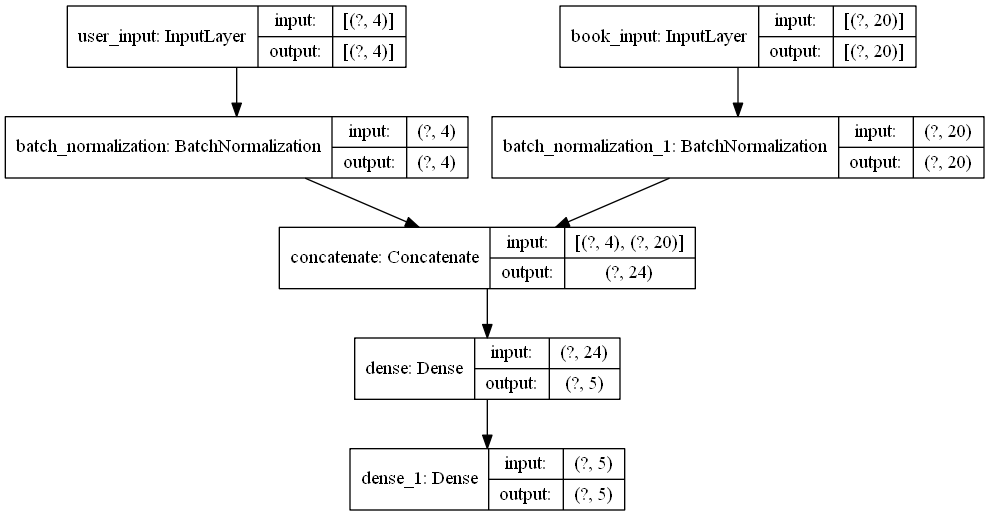

In [17]:
keras.utils.plot_model(model, 'NN.png', show_shapes=True)

In [18]:
A = np.stack(newtrain["user_feature"].values)
#A = (A - np.mean(A, axis=0)) / np.std(A, axis=0)
B = np.stack(newtrain["book_feature"].values)
#B = (B - np.mean(B, axis=0)) / np.std(B, axis=0)
model.compile(optimizer=keras.optimizers.SGD(0.01),
              loss='sparse_categorical_crossentropy',       
              metrics=['accuracy'])
model.fit({"user_input": A, "book_input": B},
           newtrain["rating"].values - 1, 
           epochs=20,
           batch_size=64)

Train on 1272599 samples
Epoch 1/20
1272599/1272599 [==============================] - 29s 23us/sample - loss: 1.3136 - accuracy: 0.3982
Epoch 2/20
1272599/1272599 [==============================] - 28s 22us/sample - loss: 1.3025 - accuracy: 0.4025
Epoch 3/20
1272599/1272599 [==============================] - 28s 22us/sample - loss: 1.3000 - accuracy: 0.4033
Epoch 4/20
1272599/1272599 [==============================] - 28s 22us/sample - loss: 1.2982 - accuracy: 0.4041
Epoch 5/20
1272599/1272599 [==============================] - 28s 22us/sample - loss: 1.2970 - accuracy: 0.4046
Epoch 6/20
1272599/1272599 [==============================] - 28s 22us/sample - loss: 1.2962 - accuracy: 0.4047
Epoch 7/20
1272599/1272599 [==============================] - 28s 22us/sample - loss: 1.2957 - accuracy: 0.4048
Epoch 8/20
1272599/1272599 [==============================] - 28s 22us/sample - loss: 1.2952 - accuracy: 0.4054
Epoch 9/20
1272599/1272599 [==============================] - 28s 22us/sample -

In [19]:
userfeature = userfeature.set_index("newuser_id")

In [20]:
reallyfinalbooks = reallyfinalbooks.set_index("newbook_id")

In [21]:
userdict = {}
bookdict = {}
for user_id in userfeature.index:
    userdict[user_id] = userfeature.loc[user_id, "user_feature"]
for book_id in reallyfinalbooks.index:
    bookdict[book_id] = reallyfinalbooks.loc[book_id, "book_feature"]

In [25]:
book_feature_list = []
for book_id in traintable.columns:
    book_feature_list.append(bookdict[book_id])
book_feature_list = np.stack(book_feature_list)

In [30]:
pred_list = []
for i, user_id in enumerate(traintable.index):
    print(i / len(traintable.index))
    pred = model.predict([userdict[user_id].reshape(1,4).repeat(len(book_feature_list), axis=0), 
                          book_feature_list]) @ np.array([1,2,3,4,5])
    pred_list.append(pred)

0.0
8.913450396648542e-05
0.00017826900793297085
0.0002674035118994563
0.0003565380158659417
0.00044567251983242714
0.0005348070237989126
0.0006239415277653979
0.0007130760317318834
0.0008022105356983688
0.0008913450396648543
0.0009804795436313396
0.0010696140475978252
0.0011587485515643105
0.0012478830555307959
0.0013370175594972814
0.0014261520634637668
0.0015152865674302523
0.0016044210713967377
0.001693555575363223
0.0017826900793297086
0.001871824583296194
0.0019609590872626793
0.002050093591229165
0.0021392280951956504
0.0022283625991621355
0.002317497103128621
0.0024066316070951066
0.0024957661110615917
0.0025849006150280773
0.002674035118994563
0.0027631696229610484
0.0028523041269275335
0.002941438630894019
0.0030305731348605047
0.0031197076388269898
0.0032088421427934753
0.003297976646759961
0.003387111150726446
0.0034762456546929316
0.003565380158659417
0.0036545146626259027
0.003743649166592388
0.0038327836705588734
0.0039219181745253585
0.0040110526784918445
0.004100187182

0.03529726357072823
0.035386398074694715
0.0354755325786612
0.035564667082627684
0.03565380158659417
0.03574293609056066
0.03583207059452714
0.03592120509849363
0.03601033960246011
0.036099474106426596
0.03618860861039308
0.03627774311435957
0.036366877618326056
0.03645601212229254
0.036545146626259024
0.03663428113022551
0.03672341563419199
0.036812550138158484
0.03690168464212497
0.03699081914609145
0.03707995365005794
0.03716908815402442
0.037258222657990905
0.0373473571619574
0.03743649166592388
0.037525626169890365
0.03761476067385685
0.037703895177823334
0.03779302968178982
0.03788216418575631
0.03797129868972279
0.03806043319368928
0.03814956769765576
0.038238702201622246
0.03832783670558873
0.03841697120955522
0.038506105713521706
0.03859524021748819
0.038684374721454674
0.03877350922542116
0.03886264372938764
0.038951778233354134
0.03904091273732062
0.0391300472412871
0.03921918174525359
0.03930831624922007
0.039397450753186555
0.039486585257153047
0.03957571976111953
0.039664

0.0715750066850878
0.07166414118905429
0.07175327569302077
0.07184241019698726
0.07193154470095374
0.07202067920492022
0.07210981370888671
0.07219894821285319
0.07228808271681968
0.07237721722078616
0.07246635172475265
0.07255548622871914
0.07264462073268563
0.07273375523665211
0.0728228897406186
0.07291202424458508
0.07300115874855156
0.07309029325251805
0.07317942775648453
0.07326856226045102
0.0733576967644175
0.07344683126838399
0.07353596577235047
0.07362510027631697
0.07371423478028345
0.07380336928424994
0.07389250378821642
0.0739816382921829
0.07407077279614939
0.07415990730011587
0.07424904180408236
0.07433817630804884
0.07442731081201533
0.07451644531598181
0.07460557981994831
0.0746947143239148
0.07478384882788128
0.07487298333184776
0.07496211783581425
0.07505125233978073
0.07514038684374721
0.0752295213477137
0.07531865585168018
0.07540779035564667
0.07549692485961315
0.07558605936357964
0.07567519386754613
0.07576432837151262
0.0758534628754791
0.07594259737944559
0.07603

0.10838755682324627
0.10847669132721277
0.10856582583117926
0.10865496033514574
0.10874409483911222
0.10883322934307871
0.10892236384704519
0.10901149835101168
0.10910063285497816
0.10918976735894464
0.10927890186291113
0.10936803636687761
0.1094571708708441
0.1095463053748106
0.10963543987877708
0.10972457438274356
0.10981370888671005
0.10990284339067653
0.10999197789464302
0.1100811123986095
0.11017024690257599
0.11025938140654247
0.11034851591050895
0.11043765041447544
0.11052678491844192
0.11061591942240842
0.1107050539263749
0.11079418843034139
0.11088332293430787
0.11097245743827436
0.11106159194224084
0.11115072644620733
0.11123986095017381
0.1113289954541403
0.11141812995810678
0.11150726446207326
0.11159639896603975
0.11168553347000625
0.11177466797397273
0.11186380247793921
0.1119529369819057
0.11204207148587218
0.11213120598983867
0.11222034049380515
0.11230947499777164
0.11239860950173812
0.1124877440057046
0.11257687850967109
0.11266601301363757
0.11275514751760407
0.11284

0.14528924146537125
0.14537837596933773
0.14546751047330422
0.1455566449772707
0.1456457794812372
0.14573491398520366
0.14582404848917016
0.14591318299313663
0.14600231749710313
0.14609145200106963
0.1461805865050361
0.1462697210090026
0.14635885551296907
0.14644799001693556
0.14653712452090203
0.14662625902486853
0.146715393528835
0.1468045280328015
0.14689366253676797
0.14698279704073447
0.14707193154470094
0.14716106604866744
0.14725020055263394
0.1473393350566004
0.1474284695605669
0.14751760406453338
0.14760673856849987
0.14769587307246634
0.14778500757643284
0.1478741420803993
0.1479632765843658
0.14805241108833228
0.14814154559229878
0.14823068009626528
0.14831981460023175
0.14840894910419825
0.14849808360816472
0.14858721811213121
0.14867635261609768
0.14876548712006418
0.14885462162403065
0.14894375612799715
0.14903289063196362
0.14912202513593012
0.14921115963989662
0.1493002941438631
0.1493894286478296
0.14947856315179606
0.14956769765576255
0.14965683215972903
0.14974596666

0.18245832961939568
0.18254746412336215
0.18263659862732864
0.18272573313129511
0.1828148676352616
0.18290400213922808
0.18299313664319458
0.18308227114716108
0.18317140565112755
0.18326054015509405
0.18334967465906052
0.18343880916302702
0.1835279436669935
0.18361707817095999
0.18370621267492646
0.18379534717889295
0.18388448168285942
0.18397361618682592
0.1840627506907924
0.1841518851947589
0.1842410196987254
0.18433015420269186
0.18441928870665836
0.18450842321062483
0.18459755771459133
0.1846866922185578
0.1847758267225243
0.18486496122649076
0.18495409573045726
0.18504323023442373
0.18513236473839023
0.18522149924235673
0.1853106337463232
0.1853997682502897
0.18548890275425617
0.18557803725822267
0.18566717176218914
0.18575630626615564
0.1858454407701221
0.1859345752740886
0.18602370977805507
0.18611284428202157
0.18620197878598804
0.18629111328995454
0.18638024779392104
0.1864693822978875
0.186558516801854
0.18664765130582048
0.18673678580978698
0.18682592031375345
0.186915054817

0.2195382832694536
0.2196274177734201
0.21971655227738657
0.21980568678135307
0.21989482128531954
0.21998395578928603
0.2200730902932525
0.220162224797219
0.2202513593011855
0.22034049380515197
0.22042962830911847
0.22051876281308494
0.22060789731705144
0.2206970318210179
0.2207861663249844
0.22087530082895088
0.22096443533291737
0.22105356983688385
0.22114270434085034
0.22123183884481684
0.2213209733487833
0.2214101078527498
0.22149924235671628
0.22158837686068278
0.22167751136464925
0.22176664586861575
0.22185578037258222
0.22194491487654872
0.22203404938051519
0.22212318388448168
0.22221231838844815
0.22230145289241465
0.22239058739638115
0.22247972190034762
0.22256885640431412
0.2226579909082806
0.2227471254122471
0.22283625991621356
0.22292539442018006
0.22301452892414653
0.22310366342811302
0.2231927979320795
0.223281932436046
0.2233710669400125
0.22346020144397896
0.22354933594794546
0.22363847045191193
0.22372760495587843
0.2238167394598449
0.2239058739638114
0.2239950084677778

0.25670737142347805
0.2567965059274445
0.256885640431411
0.25697477493537746
0.257063909439344
0.25715304394331046
0.2572421784472769
0.25733131295124345
0.2574204474552099
0.2575095819591764
0.25759871646314286
0.2576878509671094
0.25777698547107586
0.25786611997504233
0.2579552544790088
0.2580443889829753
0.2581335234869418
0.25822265799090827
0.2583117924948748
0.25840092699884126
0.25849006150280773
0.2585791960067742
0.25866833051074073
0.2587574650147072
0.25884659951867367
0.25893573402264014
0.25902486852660667
0.25911400303057314
0.2592031375345396
0.25929227203850613
0.2593814065424726
0.2594705410464391
0.25955967555040554
0.25964881005437207
0.25973794455833854
0.259827079062305
0.2599162135662715
0.260005348070238
0.2600944825742045
0.26018361707817095
0.2602727515821374
0.26036188608610394
0.2604510205900704
0.2605401550940369
0.2606292895980034
0.2607184241019699
0.26080755860593635
0.2608966931099028
0.26098582761386935
0.2610749621178358
0.2611640966218023
0.2612532311

0.29441126660130135
0.2945004011052679
0.29458953560923434
0.2946786701132008
0.2947678046171673
0.2948569391211338
0.2949460736251003
0.29503520812906675
0.2951243426330332
0.29521347713699975
0.2953026116409662
0.2953917461449327
0.2954808806488992
0.2955700151528657
0.29565914965683215
0.2957482841607986
0.29583741866476515
0.2959265531687316
0.2960156876726981
0.29610482217666456
0.2961939566806311
0.29628309118459756
0.29637222568856403
0.29646136019253055
0.296550494696497
0.2966396292004635
0.29672876370442997
0.2968178982083965
0.29690703271236296
0.29699616721632943
0.2970853017202959
0.29717443622426243
0.2972635707282289
0.29735270523219537
0.2974418397361619
0.29753097424012837
0.29762010874409484
0.2977092432480613
0.29779837775202783
0.2978875122559943
0.2979766467599608
0.29806578126392724
0.29815491576789377
0.29824405027186024
0.2983331847758267
0.29842231927979324
0.2985114537837597
0.2986005882877262
0.29868972279169265
0.2987788572956592
0.29886799179962564
0.298957

0.3321151617791247
0.33220429628309117
0.3322934307870577
0.33238256529102417
0.33247169979499064
0.3325608342989571
0.33264996880292363
0.3327391033068901
0.3328282378108566
0.33291737231482305
0.33300650681878957
0.33309564132275604
0.3331847758267225
0.333273910330689
0.3333630448346555
0.333452179338622
0.33354131384258845
0.333630448346555
0.33371958285052145
0.3338087173544879
0.3338978518584544
0.3339869863624209
0.3340761208663874
0.33416525537035385
0.3342543898743203
0.33434352437828685
0.3344326588822533
0.3345217933862198
0.3346109278901863
0.3347000623941528
0.33478919689811926
0.3348783314020857
0.33496746590605225
0.3350566004100187
0.3351457349139852
0.33523486941795166
0.3353240039219182
0.33541313842588466
0.33550227292985113
0.33559140743381766
0.3356805419377841
0.3357696764417506
0.33585881094571707
0.3359479454496836
0.33603707995365006
0.33612621445761653
0.336215348961583
0.33630448346554953
0.336393617969516
0.33648275247348247
0.336571886977449
0.3366610214814

0.36981905695694806
0.3699081914609145
0.369997325964881
0.37008646046884747
0.370175594972814
0.37026472947678046
0.37035386398074693
0.37044299848471346
0.37053213298867993
0.3706212674926464
0.37071040199661287
0.3707995365005794
0.37088867100454587
0.37097780550851234
0.3710669400124788
0.37115607451644533
0.3712452090204118
0.3713343435243783
0.37142347802834474
0.37151261253231127
0.37160174703627774
0.3716908815402442
0.37178001604421074
0.3718691505481772
0.3719582850521437
0.37204741955611015
0.3721365540600767
0.37222568856404314
0.3723148230680096
0.3724039575719761
0.3724930920759426
0.3725822265799091
0.37267136108387555
0.3727604955878421
0.37284963009180855
0.372938764595775
0.3730278990997415
0.373117033603708
0.3732061681076745
0.37329530261164096
0.3733844371156074
0.37347357161957395
0.3735627061235404
0.3736518406275069
0.3737409751314734
0.3738301096354399
0.37391924413940636
0.37400837864337283
0.37409751314733936
0.3741866476513058
0.3742757821552723
0.3743649166

0.40752295213477135
0.4076120866387379
0.40770122114270435
0.4077903556466708
0.4078794901506373
0.4079686246546038
0.4080577591585703
0.40814689366253676
0.40823602816650323
0.40832516267046975
0.4084142971744362
0.4085034316784027
0.4085925661823692
0.4086817006863357
0.40877083519030216
0.40885996969426863
0.40894910419823516
0.40903823870220163
0.4091273732061681
0.40921650771013457
0.4093056422141011
0.40939477671806757
0.40948391122203404
0.40957304572600056
0.40966218022996703
0.4097513147339335
0.4098404492379
0.4099295837418665
0.41001871824583297
0.41010785274979944
0.4101969872537659
0.41028612175773244
0.4103752562616989
0.4104643907656654
0.41055352526963185
0.4106426597735984
0.41073179427756484
0.4108209287815313
0.41091006328549784
0.4109991977894643
0.4110883322934308
0.41117746679739725
0.4112666013013638
0.41135573580533025
0.4114448703092967
0.4115340048132632
0.4116231393172297
0.4117122738211962
0.41180140832516265
0.4118905428291292
0.41197967733309565
0.41206881

0.4452268473125947
0.4453159818165612
0.44540511632052765
0.4454942508244942
0.44558338532846065
0.4456725198324271
0.44576165433639364
0.4458507888403601
0.4459399233443266
0.44602905784829305
0.4461181923522596
0.44620732685622605
0.4462964613601925
0.446385595864159
0.4464747303681255
0.446563864872092
0.44665299937605846
0.446742133880025
0.44683126838399145
0.4469204028879579
0.4470095373919244
0.4470986718958909
0.4471878063998574
0.44727694090382386
0.44736607540779033
0.44745520991175686
0.4475443444157233
0.4476334789196898
0.4477226134236563
0.4478117479276228
0.44790088243158926
0.44799001693555573
0.44807915143952226
0.44816828594348873
0.4482574204474552
0.44834655495142167
0.4484356894553882
0.44852482395935467
0.44861395846332114
0.44870309296728766
0.44879222747125413
0.4488813619752206
0.4489704964791871
0.4490596309831536
0.44914876548712007
0.44923789999108654
0.449327034495053
0.44941616899901954
0.449505303502986
0.4495944380069525
0.44968357251091895
0.44977270701

0.48293074249041806
0.48301987699438453
0.483109011498351
0.4831981460023175
0.483287280506284
0.48337641501025047
0.48346554951421694
0.4835546840181834
0.48364381852214994
0.4837329530261164
0.4838220875300829
0.4839112220340494
0.4840003565380159
0.48408949104198234
0.4841786255459488
0.48426776004991534
0.4843568945538818
0.4844460290578483
0.48453516356181475
0.4846242980657813
0.48471343256974775
0.4848025670737142
0.48489170157768074
0.4849808360816472
0.4850699705856137
0.48515910508958016
0.4852482395935467
0.48533737409751315
0.4854265086014796
0.4855156431054461
0.4856047776094126
0.4856939121133791
0.48578304661734556
0.4858721811213121
0.48596131562527856
0.486050450129245
0.4861395846332115
0.486228719137178
0.4863178536411445
0.48640698814511096
0.48649612264907743
0.48658525715304396
0.48667439165701043
0.4867635261609769
0.4868526606649434
0.4869417951689099
0.48703092967287637
0.48712006417684284
0.48720919868080936
0.48729833318477583
0.4873874676887423
0.48747660219

0.5212585791960068
0.5213477136999732
0.5214368482039398
0.5215259827079062
0.5216151172118727
0.5217042517158392
0.5217933862198056
0.5218825207237722
0.5219716552277387
0.5220607897317051
0.5221499242356716
0.5222390587396382
0.5223281932436046
0.5224173277475711
0.5225064622515375
0.522595596755504
0.5226847312594706
0.522773865763437
0.5228630002674035
0.52295213477137
0.5230412692753365
0.523130403779303
0.5232195382832695
0.5233086727872359
0.5233978072912024
0.5234869417951689
0.5235760762991354
0.5236652108031019
0.5237543453070683
0.5238434798110349
0.5239326143150014
0.5240217488189678
0.5241108833229343
0.5242000178269008
0.5242891523308673
0.5243782868348338
0.5244674213388002
0.5245565558427667
0.5246456903467333
0.5247348248506997
0.5248239593546662
0.5249130938586327
0.5250022283625991
0.5250913628665657
0.5251804973705322
0.5252696318744986
0.5253587663784651
0.5254479008824315
0.5255370353863981
0.5256261698903646
0.525715304394331
0.5258044388982975
0.5258935734022641

0.5600320884214279
0.5601212229253945
0.5602103574293609
0.5602994919333274
0.5603886264372939
0.5604777609412603
0.5605668954452269
0.5606560299491933
0.5607451644531598
0.5608342989571263
0.5609234334610927
0.5610125679650593
0.5611017024690258
0.5611908369729922
0.5612799714769587
0.5613691059809253
0.5614582404848917
0.5615473749888582
0.5616365094928246
0.5617256439967911
0.5618147785007577
0.5619039130047241
0.5619930475086906
0.5620821820126571
0.5621713165166236
0.5622604510205901
0.5623495855245566
0.562438720028523
0.5625278545324895
0.562616989036456
0.5627061235404225
0.562795258044389
0.5628843925483554
0.562973527052322
0.5630626615562885
0.5631517960602549
0.5632409305642214
0.563330065068188
0.5634191995721544
0.5635083340761209
0.5635974685800873
0.5636866030840538
0.5637757375880204
0.5638648720919868
0.5639540065959533
0.5640431410999198
0.5641322756038862
0.5642214101078528
0.5643105446118193
0.5643996791157857
0.5644888136197522
0.5645779481237186
0.564667082627685

0.5987164631428826
0.598805597646849
0.5988947321508156
0.5989838666547821
0.5990730011587485
0.599162135662715
0.5992512701666816
0.599340404670648
0.5994295391746145
0.599518673678581
0.5996078081825474
0.599696942686514
0.5997860771904804
0.5998752116944469
0.5999643461984134
0.6000534807023798
0.6001426152063464
0.6002317497103129
0.6003208842142793
0.6004100187182458
0.6004991532222124
0.6005882877261788
0.6006774222301453
0.6007665567341117
0.6008556912380782
0.6009448257420448
0.6010339602460112
0.6011230947499777
0.6012122292539442
0.6013013637579107
0.6013904982618772
0.6014796327658437
0.6015687672698101
0.6016579017737766
0.6017470362777431
0.6018361707817096
0.6019253052856761
0.6020144397896425
0.6021035742936091
0.6021927087975756
0.602281843301542
0.6023709778055085
0.602460112309475
0.6025492468134415
0.602638381317408
0.6027275158213744
0.6028166503253409
0.6029057848293075
0.6029949193332739
0.6030840538372404
0.6031731883412069
0.6032623228451733
0.6033514573491399
0

0.6374899723683037
0.6375791068722703
0.6376682413762368
0.6377573758802032
0.6378465103841697
0.6379356448881361
0.6380247793921027
0.6381139138960692
0.6382030484000356
0.6382921829040021
0.6383813174079687
0.6384704519119351
0.6385595864159016
0.6386487209198681
0.6387378554238345
0.6388269899278011
0.6389161244317675
0.639005258935734
0.6390943934397005
0.639183527943667
0.6392726624476335
0.6393617969516
0.6394509314555664
0.6395400659595329
0.6396292004634995
0.6397183349674659
0.6398074694714324
0.6398966039753988
0.6399857384793654
0.6400748729833319
0.6401640074872983
0.6402531419912648
0.6403422764952313
0.6404314109991978
0.6405205455031643
0.6406096800071308
0.6406988145110972
0.6407879490150638
0.6408770835190302
0.6409662180229967
0.6410553525269632
0.6411444870309296
0.6412336215348962
0.6413227560388627
0.6414118905428291
0.6415010250467956
0.6415901595507622
0.6416792940547286
0.6417684285586951
0.6418575630626615
0.641946697566628
0.6420358320705946
0.642124966574561


0.676263481593725
0.6763526160976914
0.6764417506016579
0.6765308851056244
0.6766200196095908
0.6767091541135574
0.6767982886175239
0.6768874231214903
0.6769765576254568
0.6770656921294232
0.6771548266333898
0.6772439611373563
0.6773330956413227
0.6774222301452892
0.6775113646492558
0.6776004991532222
0.6776896336571887
0.6777787681611552
0.6778679026651216
0.6779570371690882
0.6780461716730546
0.6781353061770211
0.6782244406809876
0.678313575184954
0.6784027096889206
0.6784918441928871
0.6785809786968535
0.67867011320082
0.6787592477047866
0.678848382208753
0.6789375167127195
0.6790266512166859
0.6791157857206525
0.679204920224619
0.6792940547285854
0.6793831892325519
0.6794723237365184
0.6795614582404849
0.6796505927444514
0.6797397272484179
0.6798288617523843
0.6799179962563509
0.6800071307603173
0.6800962652642838
0.6801853997682503
0.6802745342722167
0.6803636687761833
0.6804528032801498
0.6805419377841162
0.6806310722880827
0.6807202067920493
0.6808093412960157
0.6808984757999822

0.7149478563151797
0.7150369908191461
0.7151261253231126
0.715215259827079
0.7153043943310455
0.7153935288350121
0.7154826633389785
0.715571797842945
0.7156609323469115
0.7157500668508779
0.7158392013548445
0.715928335858811
0.7160174703627774
0.7161066048667439
0.7161957393707103
0.7162848738746769
0.7163740083786434
0.7164631428826098
0.7165522773865763
0.7166414118905429
0.7167305463945093
0.7168196808984758
0.7169088154024423
0.7169979499064087
0.7170870844103753
0.7171762189143417
0.7172653534183082
0.7173544879222747
0.7174436224262412
0.7175327569302077
0.7176218914341742
0.7177110259381406
0.7178001604421071
0.7178892949460737
0.7179784294500401
0.7180675639540066
0.718156698457973
0.7182458329619396
0.7183349674659061
0.7184241019698725
0.718513236473839
0.7186023709778055
0.718691505481772
0.7187806399857385
0.718869774489705
0.7189589089936714
0.719048043497638
0.7191371780016044
0.7192263125055709
0.7193154470095374
0.7194045815135038
0.7194937160174704
0.7195828505214369
0

0.7537213655406008
0.7538105000445673
0.7538996345485337
0.7539887690525002
0.7540779035564668
0.7541670380604332
0.7542561725643997
0.7543453070683661
0.7544344415723326
0.7545235760762992
0.7546127105802656
0.7547018450842321
0.7547909795881986
0.754880114092165
0.7549692485961316
0.7550583831000981
0.7551475176040645
0.755236652108031
0.7553257866119975
0.755414921115964
0.7555040556199305
0.7555931901238969
0.7556823246278634
0.75577145913183
0.7558605936357964
0.7559497281397629
0.7560388626437294
0.7561279971476959
0.7562171316516624
0.7563062661556288
0.7563954006595953
0.7564845351635618
0.7565736696675283
0.7566628041714948
0.7567519386754613
0.7568410731794277
0.7569302076833943
0.7570193421873608
0.7571084766913272
0.7571976111952937
0.7572867456992601
0.7573758802032267
0.7574650147071932
0.7575541492111596
0.7576432837151261
0.7577324182190927
0.7578215527230591
0.7579106872270256
0.7579998217309921
0.7580889562349585
0.7581780907389251
0.7582672252428915
0.758356359746858

0.7924948747660219
0.7925840092699884
0.7926731437739549
0.7927622782779213
0.7928514127818879
0.7929405472858544
0.7930296817898208
0.7931188162937873
0.7932079507977539
0.7932970853017203
0.7933862198056868
0.7934753543096532
0.7935644888136197
0.7936536233175863
0.7937427578215527
0.7938318923255192
0.7939210268294857
0.7940101613334521
0.7940992958374187
0.7941884303413852
0.7942775648453516
0.7943666993493181
0.7944558338532846
0.7945449683572511
0.7946341028612176
0.794723237365184
0.7948123718691505
0.7949015063731171
0.7949906408770835
0.79507977538105
0.7951689098850165
0.795258044388983
0.7953471788929495
0.7954363133969159
0.7955254479008824
0.795614582404849
0.7957037169088154
0.7957928514127819
0.7958819859167484
0.7959711204207148
0.7960602549246814
0.7961493894286479
0.7962385239326143
0.7963276584365808
0.7964167929405472
0.7965059274445138
0.7965950619484803
0.7966841964524467
0.7967733309564132
0.7968624654603798
0.7969515999643462
0.7970407344683127
0.797129868972279

0.8311792494874766
0.8312683839914431
0.8313575184954096
0.831446652999376
0.8315357875033426
0.831624922007309
0.8317140565112755
0.831803191015242
0.8318923255192084
0.831981460023175
0.8320705945271415
0.8321597290311079
0.8322488635350744
0.832337998039041
0.8324271325430074
0.8325162670469739
0.8326054015509403
0.8326945360549068
0.8327836705588734
0.8328728050628398
0.8329619395668063
0.8330510740707728
0.8331402085747392
0.8332293430787058
0.8333184775826723
0.8334076120866387
0.8334967465906052
0.8335858810945717
0.8336750155985382
0.8337641501025047
0.8338532846064711
0.8339424191104376
0.8340315536144042
0.8341206881183706
0.8342098226223371
0.8342989571263036
0.8343880916302701
0.8344772261342366
0.834566360638203
0.8346554951421695
0.834744629646136
0.8348337641501025
0.834922898654069
0.8350120331580355
0.8351011676620019
0.8351903021659685
0.835279436669935
0.8353685711739014
0.8354577056778679
0.8355468401818343
0.8356359746858009
0.8357251091897674
0.8358142436937338
0.

0.8699527587128978
0.8700418932168642
0.8701310277208307
0.8702201622247973
0.8703092967287637
0.8703984312327302
0.8704875657366967
0.8705767002406631
0.8706658347446297
0.8707549692485961
0.8708441037525626
0.8709332382565291
0.8710223727604955
0.8711115072644621
0.8712006417684286
0.871289776272395
0.8713789107763615
0.8714680452803281
0.8715571797842945
0.871646314288261
0.8717354487922274
0.871824583296194
0.8719137178001605
0.8720028523041269
0.8720919868080934
0.8721811213120599
0.8722702558160264
0.8723593903199929
0.8724485248239594
0.8725376593279258
0.8726267938318923
0.8727159283358588
0.8728050628398253
0.8728941973437918
0.8729833318477582
0.8730724663517248
0.8731616008556913
0.8732507353596577
0.8733398698636242
0.8734290043675907
0.8735181388715572
0.8736072733755237
0.8736964078794901
0.8737855423834566
0.8738746768874232
0.8739638113913896
0.8740529458953561
0.8741420803993226
0.874231214903289
0.8743203494072556
0.8744094839112221
0.8744986184151885
0.87458775291915

0.9087262679383189
0.9088154024422854
0.9089045369462518
0.9089936714502184
0.9090828059541849
0.9091719404581513
0.9092610749621178
0.9093502094660844
0.9094393439700508
0.9095284784740173
0.9096176129779838
0.9097067474819502
0.9097958819859168
0.9098850164898832
0.9099741509938497
0.9100632854978162
0.9101524200017826
0.9102415545057492
0.9103306890097157
0.9104198235136821
0.9105089580176486
0.9105980925216152
0.9106872270255816
0.9107763615295481
0.9108654960335145
0.910954630537481
0.9110437650414476
0.911132899545414
0.9112220340493805
0.911311168553347
0.9114003030573135
0.91148943756128
0.9115785720652465
0.9116677065692129
0.9117568410731794
0.9118459755771459
0.9119351100811124
0.9120242445850789
0.9121133790890453
0.9122025135930119
0.9122916480969784
0.9123807826009448
0.9124699171049113
0.9125590516088778
0.9126481861128443
0.9127373206168108
0.9128264551207772
0.9129155896247437
0.9130047241287103
0.9130938586326767
0.9131829931366432
0.9132721276406097
0.913361262144576

0.9474106426597736
0.9474997771637401
0.9475889116677065
0.9476780461716731
0.9477671806756396
0.947856315179606
0.9479454496835725
0.9480345841875389
0.9481237186915055
0.948212853195472
0.9483019876994384
0.9483911222034049
0.9484802567073715
0.9485693912113379
0.9486585257153044
0.9487476602192709
0.9488367947232373
0.9489259292272039
0.9490150637311703
0.9491041982351368
0.9491933327391033
0.9492824672430697
0.9493716017470363
0.9494607362510028
0.9495498707549692
0.9496390052589357
0.9497281397629023
0.9498172742668687
0.9499064087708352
0.9499955432748016
0.9500846777787681
0.9501738122827347
0.9502629467867011
0.9503520812906676
0.9504412157946341
0.9505303502986006
0.9506194848025671
0.9507086193065336
0.9507977538105
0.9508868883144665
0.950976022818433
0.9510651573223995
0.951154291826366
0.9512434263303324
0.951332560834299
0.9514216953382655
0.9515108298422319
0.9515999643461984
0.951689098850165
0.9517782333541314
0.9518673678580979
0.9519565023620643
0.9520456368660308
0.

0.9861841518851947
0.9862732863891612
0.9863624208931278
0.9864515553970942
0.9865406899010607
0.9866298244050272
0.9867189589089936
0.9868080934129602
0.9868972279169267
0.9869863624208931
0.9870754969248596
0.987164631428826
0.9872537659327926
0.9873429004367591
0.9874320349407255
0.987521169444692
0.9876103039486586
0.987699438452625
0.9877885729565915
0.987877707460558
0.9879668419645244
0.988055976468491
0.9881451109724574
0.9882342454764239
0.9883233799803904
0.9884125144843569
0.9885016489883234
0.9885907834922899
0.9886799179962563
0.9887690525002228
0.9888581870041894
0.9889473215081558
0.9890364560121223
0.9891255905160887
0.9892147250200553
0.9893038595240218
0.9893929940279882
0.9894821285319547
0.9895712630359212
0.9896603975398877
0.9897495320438542
0.9898386665478207
0.9899278010517871
0.9900169355557537
0.9901060700597201
0.9901952045636866
0.9902843390676531
0.9903734735716195
0.9904626080755861
0.9905517425795526
0.990640877083519
0.9907300115874855
0.990819146091452


In [31]:
userid2preds = {}
userid2pred_ratings = {}
userids = list(reallyfinalratings["newuser_id"].unique())

pred_table = pd.DataFrame(data=np.stack(pred_list), index=traintable.index, columns=traintable.columns)

In [36]:
reallyfinalbooks = reallyfinalbooks.reset_index()

In [37]:
%%time

for counter, userid in enumerate(userids):
    if (counter % 500 == 0):
        print(counter)
    userid2usertraindata = train[train["newuser_id"] == userid]
    pred =  (reallyfinalbooks[["newbook_id"]]
            .assign(pred_rating=pred_table.loc[userid])
            .sort_values(by="pred_rating", ascending=False)
            .assign(rank=np.arange(1, len(reallyfinalbooks)+1))
            .sort_values(by="newbook_id")
            .set_index("newbook_id"))
    userid2preds[userid] = pred
    userid2pred_ratings[userid] = pred["pred_rating"]

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
Wall time: 1min 35s


In [41]:
train_rmse = rmse(traintable.values, np.stack(pred_list))
test_rmse = rmse(testtable.values, np.stack(pred_list))

In [50]:
%%time
train_rs = []
test_rs = []
for userid in userids:
    train_rs.append(train[train["newuser_id"] == userid]
                    .merge(userid2preds[userid].reset_index(), on="newbook_id", how="left")
                    .sort_values(by="rank")["rating"])
    test_rs.append(test[test["newuser_id"] == userid]
                   .merge(userid2preds[userid].reset_index(), on="newbook_id", how="left")
                   .sort_values(by="rank")["rating"])

train_ndgc = np.mean([ndcg_k(r) for r in train_rs])
test_ndgc = np.mean([ndcg_k(r) for r in test_rs])

Wall time: 2min 26s


In [51]:
%%time
diversityScore = np.mean([divSco_k(pred.sort_values(by="rank").index,tail["newbook_id"].values) for pred in list(userid2preds.values())])

Wall time: 21.1 s


In [56]:
print("NN Model")
print("RMSE for train data: {:.3f}, test data: {:.3f}".format(train_rmse, test_rmse))
print("nDGC for train data: {:.3f}, test data: {:.3f}".format(train_ndgc, test_ndgc))
print("Diversity Score: {:.3f}".format(diversityScore))

NN Model
RMSE for train data: 0.856, test data: 0.891
nDGC for train data: 0.602, test data: 0.686
Diversity Score: 0.212
